# ODS – Etapa 1 (Clasificación de texto)
**Objetivo:** clasificar opiniones a ODS 1/3/4 con modelos supervisados.
Estructura:
1) Entendimiento de los datos
2) Preparación (TF-IDF)
3) Modelos base 
4) Ajuste de hiperparámetros (GridSearchCV)
5) Interpretación (términos top)
6) Exportables (predicciones y modelo)

## 1. Imports y configuración

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_selection import chi2
from joblib import dump

plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["axes.grid"] = True

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE) # Buena practica para reproducibilidad segun la ia 


## 2. Carga de datos

In [2]:


DATA_PATH   = "Datos_proyecto.xlsx"  
DATA_PATH_TEST = "Datos de prueba_proyecto.xlsx"        
TEXT_COL    = "textos"                       
LABEL_COL   = "labels"

xls = pd.ExcelFile(DATA_PATH)
print("Hojas:", xls.sheet_names)
df = pd.read_excel(DATA_PATH, sheet_name=xls.sheet_names[0])
df = df[[TEXT_COL, LABEL_COL]].rename(columns={TEXT_COL:"textos", LABEL_COL:"labels"})
test_data= pd.read_excel(DATA_PATH_TEST)
df.head(10)

Hojas: ['Sheet1']


,textos,labels
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4
1,Para los niños más pequeños (bebés y niños peq...,4
2,"Además, la formación de especialistas en medic...",3
3,En los países de la OCDE se tiende a pasar de ...,4
4,Este grupo se centró en las personas que padec...,3
5,Los datos a nivel del sistema que no se deriva...,4
6,La principal ventaja de las evaluaciones exter...,4
7,Los pacientes pueden elegir a cualquier médico...,3
8,"De hecho, es probable que la designación de la...",4
9,"De hecho, aunque Chile y Uruguay tienen índice...",1


## 3. Entendimiento de Datos
Aca vamos a revisar cosas como:
- Tamaños
- Vacios o NA 
- Longitudes 
- Distribución de los Labels


In [3]:
print("Dimensiones:", df.shape)
display(df.info())

Dimensiones: (2424, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2424 entries, 0 to 2423
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   textos  2424 non-null   object
 1   labels  2424 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 38.0+ KB


None

In [4]:
# Longitud de textos
df["len_words"] = df["textos"].astype(str).str.split().str.len()
df["len_chars"] = df["textos"].astype(str).str.len()
df[["len_words","len_chars"]].describe().T

,count,mean,std,min,25%,50%,75%,max
len_words,2424.0,107.924092,35.575349,41.0,81.0,102.0,129.00,260.0
len_chars,2424.0,683.223185,223.563695,303.0,513.0,647.0,809.25,1492.0


### Unicidad
Eliminar duplicados

In [5]:
# NA y duplicados
print("NA por columna:\n", df.isna().sum())
dup_text = df.duplicated(subset=["textos"]).sum()
dup_both = df.duplicated(subset=["textos","labels"]).sum()
print(f"Duplicados de texto: {dup_text} | Duplicados (texto + etiqueta): {dup_both}")

NA por columna:
 textos       0
labels       0
len_words    0
len_chars    0
dtype: int64
Duplicados de texto: 0 | Duplicados (texto + etiqueta): 0


### Completitud
Eliminar textos vacios o con menos de tres palabras

In [6]:
df = df.dropna(subset=["textos"]).copy()
df = df[df["textos"].astype(str).str.strip() != ""]
MIN_WORDS = 3
df = df[df["len_words"] > MIN_WORDS].copy()

print("Tras limpieza básica:", df.shape)

# No habian vacios ni duplicados

Tras limpieza básica: (2424, 4)


### Distribución de etiquetas

labels
4    1025
3     894
1     505
Name: count, dtype: int64

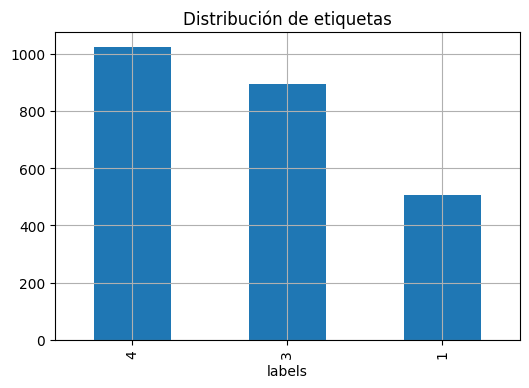

In [7]:
# Distribución de los labels
counts = df["labels"].value_counts()
counts.plot.bar(title="Distribución de etiquetas")
counts

# Los resultados muestran que hay un desbalance en las clases, 
# se debe considerar hacer aumentación de datos con ia generativa (Es para entrega 2)

### Normalización y estematización

In [8]:
# Stopwords en español, de lo que vi, esto nos va a ayudar ya que hay muchas palabras comunes en los textos
# que no aportan mucho valor para la clasificación y pueden introducir ruido en el modelo y asi nos 
# aseguramos que el modelo se enfoque en las palabras más relevantes para la clasificación (e.g. salud, educación, pobreza, etc)
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

spanish_stopwords = stopwords.words("spanish")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lila\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
import re
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer
from nltk.stem.snowball import SnowballStemmer

# Prepara herramientas
wpt = WordPunctTokenizer()
ps = SnowballStemmer("spanish")
spanish_stopwords = set(stopwords.words("spanish"))

def normalize_text(doc):
    # Limpieza de caracteres
    doc = re.sub(r'[^a-zA-ZáéíóúÁÉÍÓÚ\s]', '', doc, re.I|re.A)
    doc = doc.lower().strip()
    
    # Tokenización
    tokens = wpt.tokenize(doc)
    
    # Quitar stopwords + stemming
    filtered_tokens = [ps.stem(token) for token in tokens if token not in spanish_stopwords]
    
    return ' '.join(filtered_tokens)

# Aplicar a todo el DataFrame
normalize_data = np.vectorize(normalize_text)
norm_data = normalize_data(df["textos"].astype(str))

def norm_all_data (data):
    normalize_data = np.vectorize(normalize_text)
    norm_data = normalize_data(data.astype(str))
    return norm_data


C:\Users\Lila\AppData\Local\Temp\ipykernel_23308\1566220604.py:14: DeprecationWarning: 'count' is passed as positional argument
  doc = re.sub(r'[^a-zA-ZáéíóúÁÉÍÓÚ\s]', '', doc, re.I|re.A)


In [10]:
#Split de datos de entrenamiento, prueba y validación (70%, 20%, 10%) 
X = norm_data
y = df["labels"]

X_train, X_t, y_train, y_t = train_test_split(X, y, test_size=0.30, random_state=RANDOM_STATE, stratify=y)

X_test, X_val, y_test, y_val = train_test_split(X_t, y_t, test_size=0.30, random_state=RANDOM_STATE, stratify=y_t)


### Vectorización TF-IDF

In [11]:
# Vectorización TF-IDF, eso es Term Frequency–Inverse Document Frequency (lo vimos en clase)
# Entonces las palabras que aparecen en muchos documentos (alta frecuencia) tienen menos peso
# y las que aparecen en pocos documentos (baja frecuencia) tienen más peso
#Mejores params: {'knn__metric': 'cosine', 'knn__n_neighbors': 11, 'knn__weights': 'distance', 'tfidf__max_df': 0.85, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2)}

tfidf = TfidfVectorizer(
    strip_accents="unicode",
    token_pattern=r"(?u)\b\w\w+\b",   
    ngram_range=(1,2),
    min_df=2,
    max_df=0.85
)
# Ajustar 
X_train_tfidf = tfidf.fit_transform(X_train)
# Transformar
X_test_tfidf  = tfidf.transform(X_test)

X_train_tfidf.shape, X_test_tfidf.shape

((1696, 13057), (509, 13057))

## Modelos
En esta primera iteración vamos a montar los 3 algoritmos vistos en clase: arbol de decisión, KNN y Naive Bayes.

In [12]:
# Vamos a probar varios modelos de clasificación con hiperparámetros estandar a ver como nos va  
models = { 
    "KNN": KNeighborsClassifier(n_neighbors=11, metric="cosine", weights="distance", ),
    "Decision Tree": DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=15, min_samples_leaf=2),
    "Naive Bayes": MultinomialNB(alpha=1.0)
}

In [13]:
# Evaluar modelos 
print("Resultados de los tres modelos en Test:")
for name, model in models.items():
    print(f"Modelo: {name}")
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    print(classification_report(y_test, y_pred))

Resultados de los tres modelos en Test:
Modelo: KNN
              precision    recall  f1-score   support

           1       0.89      0.92      0.90       106
           3       0.95      0.95      0.95       188
           4       0.96      0.95      0.96       215

    accuracy                           0.94       509
   macro avg       0.93      0.94      0.94       509
weighted avg       0.94      0.94      0.94       509

Modelo: Decision Tree
              precision    recall  f1-score   support

           1       0.83      0.85      0.84       106
           3       0.85      0.90      0.88       188
           4       0.94      0.89      0.91       215

    accuracy                           0.88       509
   macro avg       0.88      0.88      0.88       509
weighted avg       0.89      0.88      0.88       509

Modelo: Naive Bayes
              precision    recall  f1-score   support

           1       0.99      0.71      0.82       106
           3       0.93      0.94  

## Modelos no vistos en clase

Ahora usaremos linear SVM (support vector machine), y probaremos que tal nos va con este. 
Decidimos probar con esta ya que investigando: encontramos que este modelo es muy bueno para clasificación de texto dado que maneja muy bien los modelos con demasiadas features (cada ngram es un feature). Cabe aclarar que en codigo usamos SVC que es la implementación de SVM que ofrece la libreria scikit-learn.

Este es un modelo de clasificación que busca un hiperplano lineal que separa las clases en el espacio de características y maximiza el margen entre las clases. La dimension del hiperplano depende de la cantidad de features, por lo que para este caso el hiperplano tiene 13057 dimensiones.


In [14]:
num_features = len(tfidf.get_feature_names_out())
print("Número de features:", num_features)

#Modelo svm
from sklearn.svm import SVC
svm_model = SVC(kernel='linear', random_state=RANDOM_STATE, C=1.0)
svm_model.fit(X_train_tfidf, y_train)
y_pred = svm_model.predict(X_test_tfidf)
print("\n SVM en test: \n")
print(classification_report(y_test, y_pred))


Número de features: 13057

 SVM en test: 

              precision    recall  f1-score   support

           1       0.95      0.89      0.92       106
           3       0.94      0.98      0.96       188
           4       0.98      0.98      0.98       215

    accuracy                           0.96       509
   macro avg       0.96      0.95      0.95       509
weighted avg       0.96      0.96      0.96       509



Por otro lado, usaremos el modelo de regresión logística multinomial. Decidimos usar este modelo, cuando realizamos la investigación este nos indicaba, que es un modelo útil para situaciones donde se puede clasificar sujetos en un conjunto de varuables predictoras. Es similar a la regresión logística, pero es algo general, puesto que la variable óbjetivo no estpa restringida a ser de dos categorías. 

In [15]:
#Modelo de regresión logística

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression

model_regression = LogisticRegression(
    solver="lbfgs", 
    max_iter=300,
    class_weight="balanced",
    random_state=42
)
model_regression.fit(X_train_tfidf, y_train)
y_pred = model_regression.predict(X_test_tfidf)
print("\n Regresión logística en test: \n")
print(classification_report(y_test, y_pred))


 Regresión logística en test: 

              precision    recall  f1-score   support

           1       0.95      0.92      0.93       106
           3       0.95      0.97      0.96       188
           4       0.98      0.98      0.98       215

    accuracy                           0.96       509
   macro avg       0.96      0.96      0.96       509
weighted avg       0.96      0.96      0.96       509



## Ajuste de Hiperparametros
Como ya tenemos los modelos montados y al evaluarlos vimos que KNN y LÑinear SVM fueron  los mejores modelos por ahora, vamos a usar GridSearchCV para encontrar los mejores parametros para estos modelos.

Fitting 5 folds for each of 48 candidates, totalling 240 fits


C:\Users\Lila\AppData\Local\Temp\ipykernel_23308\1566220604.py:14: DeprecationWarning: 'count' is passed as positional argument
  doc = re.sub(r'[^a-zA-ZáéíóúÁÉÍÓÚ\s]', '', doc, re.I|re.A)


Mejores params: {'regression__C': 1.0, 'regression__penalty': 'l2', 'tfidf__max_df': 0.85, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2)}
Mejor F1 macro: 0.98


C:\Users\Lila\AppData\Local\Temp\ipykernel_23308\1566220604.py:14: DeprecationWarning: 'count' is passed as positional argument
  doc = re.sub(r'[^a-zA-ZáéíóúÁÉÍÓÚ\s]', '', doc, re.I|re.A)



 Regresión Logística (mejor grid) en val 

              precision    recall  f1-score   support

           1      0.957     0.957     0.957        46
           3      0.988     0.988     0.988        80
           4      0.989     0.989     0.989        93

    accuracy                          0.982       219
   macro avg      0.978     0.978     0.978       219
weighted avg      0.982     0.982     0.982       219



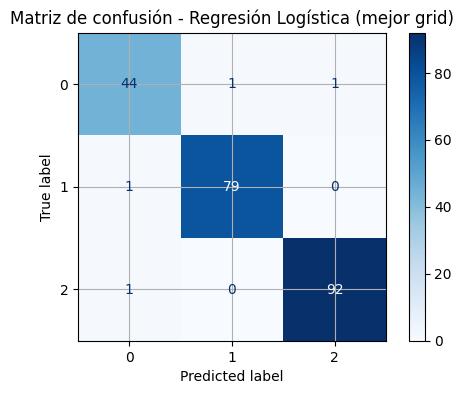

,steps,"[('normalize', ...), ('tfidf', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,func,<function nor...001A25F73F2E0>
,inverse_func,None
,validate,False
,accept_sparse,False
,check_inverse,True
,feature_names_out,None
,kw_args,None


In [ ]:
# Creamos un pipeline para encapsular el proceso de vectorización y el modelo de regresión logística
from sklearn.pipeline import FunctionTransformer
from sklearn.linear_model import LogisticRegression

X = df['textos']
y = df['labels']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y)


pipeRegression = Pipeline([
    ("normalize", FunctionTransformer(norm_all_data)),
    ("tfidf", tfidf),
    ("regression", LogisticRegression(solver='lbfgs', max_iter=300, class_weight='balanced', random_state=RANDOM_STATE))
])

# Definimos el grid de Regresión Logística
param_grid_regression = {
    "regression__C": [0.1, 1.0, 10.0],
    "regression__penalty": ["l2", None], # l1 no es compatible con lbfgs
    "tfidf__min_df": [2, 3],
    "tfidf__max_df": [0.85, 0.9],
    "tfidf__ngram_range": [(1,1),(1,2)]
}

# Configuramos el GridSearchCV para Regresión Logística
grid_regression = GridSearchCV(pipeRegression, param_grid_regression, cv=5, n_jobs=-1, verbose=2, scoring='f1_macro')
grid_regression.fit(X_train, y_train)

# Obtenemos el mejor pipeline
mejor_pipe_regression = grid_regression.best_estimator_
print("Mejores params:", grid_regression.best_params_)
print("Mejor F1 macro:", round(grid_regression.best_score_, 2))

# Evaluación en val, esto no visto por el grid
y_pred = mejor_pipe_regression.predict(X_val)
print("\n Regresión Logística (mejor grid) en datos de validación \n")
print(classification_report(y_val, y_pred, digits=3))

# Matriz de confusión
cm = confusion_matrix(y_val, y_pred, labels=[1,3,4])
ConfusionMatrixDisplay(cm).plot(cmap="Blues")
plt.title("Matriz de confusión - Regresión Logística (mejor grid)")
plt.show()


pipeRegression

In [ ]:
# Palabras más importantes por clase para Regresión Logística
import numpy as np

regression_model = grid_regression.best_estimator_.named_steps['regression']
vectorizer_regression = grid_regression.best_estimator_.named_steps['tfidf']

feature_names_regression = vectorizer_regression.get_feature_names_out()

# Iteramos por cada clase
for i, class_label in enumerate(regression_model.classes_):
    coefs = regression_model.coef_[i]  # coeficientes para la clase i

    # Top 10 palabras que favorecen la clase
    top_pos_idx = np.argsort(coefs)[-10:]
    top_pos_words = [feature_names_regression[j] for j in top_pos_idx]

    # Top 10 palabras que "desfavorecen" la clase
    top_neg_idx = np.argsort(coefs)[:10]
    top_neg_words = [feature_names_regression[j] for j in top_neg_idx]

    print(f"\nClase {class_label} - palabras más positivas:")
    print(top_pos_words)

    print(f"Clase {class_label} - palabras más negativas:")
    print(top_neg_words)

Fitting 3 folds for each of 128 candidates, totalling 384 fits


C:\Users\Lila\AppData\Local\Temp\ipykernel_23308\1566220604.py:14: DeprecationWarning: 'count' is passed as positional argument
  doc = re.sub(r'[^a-zA-ZáéíóúÁÉÍÓÚ\s]', '', doc, re.I|re.A)


Mejores params: {'knn__metric': 'cosine', 'knn__n_neighbors': 9, 'knn__weights': 'uniform', 'tfidf__max_df': 0.85, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 1)}
Mejor F1 macro: 0.96


C:\Users\Lila\AppData\Local\Temp\ipykernel_23308\1566220604.py:14: DeprecationWarning: 'count' is passed as positional argument
  doc = re.sub(r'[^a-zA-ZáéíóúÁÉÍÓÚ\s]', '', doc, re.I|re.A)



 KNN (mejor grid) en val 

              precision    recall  f1-score   support

           1      0.935     0.935     0.935        46
           3      1.000     0.988     0.994        80
           4      0.968     0.978     0.973        93

    accuracy                          0.973       219
   macro avg      0.968     0.967     0.967       219
weighted avg      0.973     0.973     0.973       219



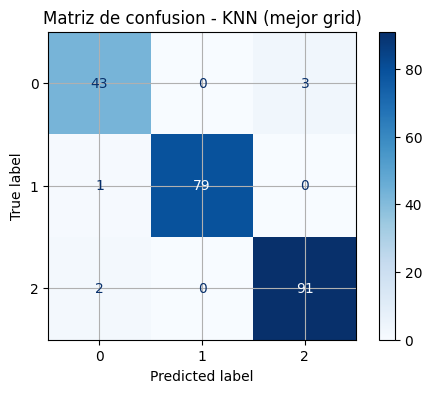

,steps,"[('normalize', ...), ('tfidf', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,func,<function nor...001A25F73F2E0>
,inverse_func,None
,validate,False
,accept_sparse,False
,check_inverse,True
,feature_names_out,None
,kw_args,None


In [ ]:
# Creamos un pipeline para encapsular el proceso de vectorización y el modelo KNN
from sklearn.pipeline import FunctionTransformer

X = df['textos']
y = df['labels']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y)

pipeKNN = Pipeline([

    ("normalize", FunctionTransformer(norm_all_data)),
    ("tfidf", tfidf),                 # usa el mismo vectorizador configurado arriba
    ("knn",  KNeighborsClassifier())  # se ajusta en el grid
])

# Definimos el grid de hiperparámetros para KNN
param_grid = {
    "knn__n_neighbors": [3,5,7,9],
    "knn__weights": ["uniform","distance"],
    "knn__metric": ["cosine","euclidean"],
    "tfidf__min_df": [2,3],
    "tfidf__max_df": [0.85,0.9],
    "tfidf__ngram_range": [(1,1),(1,2)]
}

# Configuramos el GridSearchCV
# Usamos StratifiedKFold para mantener la proporción de clases en cada fold
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
gs = GridSearchCV(pipeKNN, param_grid, scoring="f1_macro", cv=cv, n_jobs=-1, verbose=1)
gs.fit(X_train, y_train)

# Obtenemos el mejor pipeline
mejor_pipe = gs.best_estimator_
print("Mejores params:", gs.best_params_)
print("Mejor F1 macro:", round(gs.best_score_, 2))

# Evaluación con x_val, estos datos no han sido vistos por el modelo en ninguna etapa
y_pred = mejor_pipe.predict(X_val)
print("\n KNN (mejor grid) en datos de validación \n")
print(classification_report(y_val, y_pred, digits=3))

# Matriz de confusión
cm = confusion_matrix(y_val, y_pred, labels=[1,3,4])
ConfusionMatrixDisplay(cm).plot(cmap="Blues")
plt.title("Matriz de confusion - KNN (mejor grid)")
plt.show()

pipeKNN

In [17]:
tfidf_best = mejor_pipe.named_steps["tfidf"]
Xtr = tfidf_best.transform(X_train)
fn = np.array(tfidf_best.get_feature_names_out())

def top_terms_mean_tfidf(label, topn=15):
    rows = (y_train == label).values
    mean = Xtr[rows].mean(axis=0).A1
    idx = mean.argsort()[::-1][:topn]
    return fn[idx].tolist()

print("ODS1 (mean TF-IDF):", top_terms_mean_tfidf(1))
print("ODS3 (mean TF-IDF):", top_terms_mean_tfidf(3))
print("ODS4 (mean TF-IDF):", top_terms_mean_tfidf(4))

# b) Chi-cuadrado (one-vs-rest)
def top_terms_chi2(label, topn=15):
    y_bin = (y_train == label).astype(int)
    scores, _ = chi2(Xtr, y_bin)
    idx = np.argsort(scores)[-topn:][::-1]
    return fn[idx].tolist()

print("ODS1 (chi2):", top_terms_chi2(1))
print("ODS3 (chi2):", top_terms_chi2(3))
print("ODS4 (chi2):", top_terms_chi2(4))

ODS1 (mean TF-IDF): ['mas', 'esta', 'sin', 'infantil', 'social', 'estas', 'reduccion', 'si', 'hogar', 'privacion', 'desigualdad', 'umbral', 'poblacion', 'ser', 'lugar']
ODS3 (mean TF-IDF): ['mas', 'salud', 'atencion', 'esta', 'sin', 'mental', 'ocde', 'poblacion', 'estas', 'cancer', 'nacional', 'costos', 'alcohol', 'ser', 'mayor']
ODS4 (mean TF-IDF): ['mas', 'esta', 'ocde', 'escolar', 'formacion', 'nivel', 'sin', 'superior', 'profesional', 'estas', 'lugar', 'si', 'mayor', 'personal', 'preescolar']
ODS1 (chi2): ['zon', 'zeland', 'contempl', 'contamin', 'contabiliz', 'consum', 'consultori', 'consultor', 'consult', 'construct', 'constru', 'constitu', 'vulner', 'vuelv', 'vuelt']
ODS3 (chi2): ['zon', 'zeland', 'contempl', 'contamin', 'contabiliz', 'consum', 'consultori', 'consultor', 'consult', 'construct', 'constru', 'constitu', 'vulner', 'vuelv', 'vuelt']
ODS4 (chi2): ['zon', 'zeland', 'contempl', 'contamin', 'contabiliz', 'consum', 'consultori', 'consultor', 'consult', 'construct', 'const

Fitting 5 folds for each of 96 candidates, totalling 480 fits


C:\Users\Lila\AppData\Local\Temp\ipykernel_23308\1566220604.py:14: DeprecationWarning: 'count' is passed as positional argument
  doc = re.sub(r'[^a-zA-ZáéíóúÁÉÍÓÚ\s]', '', doc, re.I|re.A)


Mejores params: {'svm__C': 1.0, 'svm__class_weight': 'balanced', 'svm__loss': 'squared_hinge', 'tfidf__max_df': 0.85, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2)}
Mejor F1 macro: 0.98


C:\Users\Lila\AppData\Local\Temp\ipykernel_23308\1566220604.py:14: DeprecationWarning: 'count' is passed as positional argument
  doc = re.sub(r'[^a-zA-ZáéíóúÁÉÍÓÚ\s]', '', doc, re.I|re.A)



 SVM (mejor grid) en datos de validación 

              precision    recall  f1-score   support

           1      0.978     0.978     0.978        46
           3      0.988     1.000     0.994        80
           4      1.000     0.989     0.995        93

    accuracy                          0.991       219
   macro avg      0.989     0.989     0.989       219
weighted avg      0.991     0.991     0.991       219



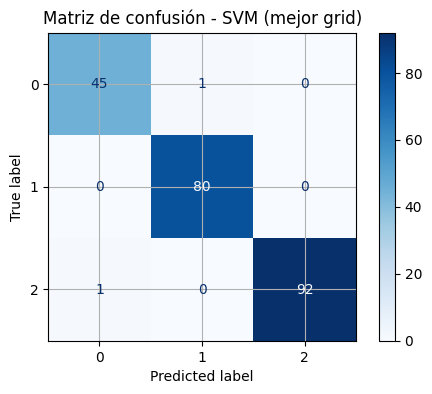

,steps,"[('normalize', ...), ('tfidf', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,func,<function nor...001A25F73F2E0>
,inverse_func,None
,validate,False
,accept_sparse,False
,check_inverse,True
,feature_names_out,None
,kw_args,None


In [18]:
#Creamos un pipeline para encapsular el proceso de vectorización y el modelo linear SVM
from sklearn.pipeline import FunctionTransformer
from sklearn.svm import LinearSVC
pipeSVM = Pipeline([
    ("normalize", FunctionTransformer(norm_all_data)),
    ("tfidf", tfidf),
    ("svm", LinearSVC())
])

# Definimos el grid de hiperparámetros para SVM
param_grid_svm = {
    "svm__C": [0.1, 1.0, 10.0],
    "svm__loss": ["hinge", "squared_hinge"],
    "svm__class_weight": [None, "balanced"],

    "tfidf__min_df": [2, 3],
    "tfidf__max_df": [0.85, 0.9],
    "tfidf__ngram_range": [(1,1),(1,2)]
    
}

# Configuramos el GridSearchCV para SVM
grid_svm = GridSearchCV(pipeSVM, param_grid_svm, cv=5, n_jobs=-1, verbose=2, scoring='f1_macro')
grid_svm.fit(X_train, y_train)

# Obtenemos el mejor pipeline
mejor_pipe_svm = grid_svm.best_estimator_
print("Mejores params:", grid_svm.best_params_)
print("Mejor F1 macro:", round(grid_svm.best_score_, 2))

# Evaluación en Val, esto no visto por el modelo en ninguna etapa
y_pred = mejor_pipe_svm.predict(X_val)
print("\n SVM (mejor grid) en datos de validación \n")
print(classification_report(y_val, y_pred, digits=3))

# Matriz de confusión
cm = confusion_matrix(y_val, y_pred, labels=[1,3,4])
ConfusionMatrixDisplay(cm).plot(cmap="Blues")
plt.title("Matriz de confusión - SVM (mejor grid)")
plt.show()


pipeSVM

In [19]:
# Palabras más importantes por clase
import numpy as np

svm = grid_svm.best_estimator_.named_steps['svm']
vectorizer = grid_svm.best_estimator_.named_steps['tfidf']

feature_names = vectorizer.get_feature_names_out()

# Iteramos por cada clase
for i, class_label in enumerate(svm.classes_):
    coefs = svm.coef_[i]  # coeficientes para la clase i

    # Top 10 palabras que favorecen la clase
    top_pos_idx = np.argsort(coefs)[-10:]
    top_pos_words = [feature_names[j] for j in top_pos_idx]

    # Top 10 palabras que "desfavorecen" la clase
    top_neg_idx = np.argsort(coefs)[:10]
    top_neg_words = [feature_names[j] for j in top_neg_idx]

    print(f"\nClase {class_label} - palabras más positivas:")
    print(top_pos_words)

    print(f"Clase {class_label} - palabras más negativas:")
    print(top_neg_words)



Clase 1 - palabras más positivas:
['emple', 'hog', 'proteccion', 'hogar', 'social', 'proteccion social', 'ingres', 'privacion', 'pobr', 'pobrez']
Clase 1 - palabras más negativas:
['salud', 'educ', 'escuel', 'medic', 'ocde', 'atencion', 'estudi', 'enfermedad', 'sanitari', 'aprendizaj']

Clase 3 - palabras más positivas:
['hospital', 'medicament', 'mental', 'mortal', 'enfermedad', 'pacient', 'sanitari', 'atencion', 'medic', 'salud']
Clase 3 - palabras más negativas:
['pobrez', 'educ', 'escuel', 'estudi', 'pobr', 'alumn', 'docent', 'profesor', 'aprendizaj', 'nios']

Clase 4 - palabras más positivas:
['enseanz', 'maestr', 'habil', 'profesor', 'aprendizaj', 'alumn', 'docent', 'estudi', 'escuel', 'educ']
Clase 4 - palabras más negativas:
['salud', 'pobrez', 'medic', 'pobr', 'atencion', 'pacient', 'sanitari', 'hospital', 'mental', 'servici']


## Archivo de predicción

In [20]:
import joblib


def process_and_predict(testData):
    # Cargar el pipeline
    pipeline = joblib.load("docs/svm_pipeline.joblib")
    print("Pipeline cargado exitosamente.")

    X_test = testData["Textos_espanol"].astype(str)

    #Predecir market value
    testData["ods_predicted"] = pipeline.predict(X_test)

    testData.to_csv("docs/predictions_ods.csv", index=False)
    print("Predicciones guardadas en 'docs/predictions_ods.csv'.")

    return testData

testData = process_and_predict(test_data)
testData

Pipeline cargado exitosamente.
Predicciones guardadas en 'docs/predictions_ods.csv'.


C:\Users\Lila\AppData\Local\Temp\ipykernel_23308\1566220604.py:14: DeprecationWarning: 'count' is passed as positional argument
  doc = re.sub(r'[^a-zA-ZáéíóúÁÉÍÓÚ\s]', '', doc, re.I|re.A)


,Textos_espanol,ods_predicted
0,"El rector, que es el representante local del M...",4
1,Tenga en cuenta que todos los programas antipo...,3
2,"Debido a que son en gran medida invisibles, es...",1
3,Los recursos aún son limitados en este sector....,3
4,"Durante el período 1985-2008, la educación pri...",4
...,...,...
147,"En Croacia, Grecia y Rumanía, 1 de cada 3 niño...",1
148,El informe también es una adición oportuna a l...,1
149,"Además, de los 1200 millones que salieron de l...",1
150,Aunque el porcentaje de población en situación...,1
